# Finding Regulatory Architectures from RegulonDB

Here we look at promoters in *E. coli* and their regulatory architecture as annotated in RegulonDB. We will use two models that predict binding interactions between sigma70 factors recruiting the RNAP with DNA. One being [Brewster et al., 2012](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002811), where an energy matrix in terms of an MWC model is used. The other model is from [La Fleur et al., 2022](https://www.nature.com/articles/s41467-022-32829-5), where a machine learning model was used to predict transcription rates from any DNA sequence, measuring contributions from various components of the sequence.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (4,3)

# import fasta files
import Bio
from Bio import SeqIO

# get La Fleur model
import sys
sys.path.insert(0, '../promoter_calculator')
import Promoter_Calculator_v1_0 as pc

## Import Regulon DB tables

### Regulatory interactions

In [2]:
df_regulation = pd.read_csv("../../data/regulonDB2023/txt/regulatory_interaction.txt",
                            comment="#",
                            sep="\t",
                            names=["REGULATORY_INTERACTION_ID",
                                   "CONFORMATION_ID",
                                   "PROMOTER_ID",
                                   "SITE_ID",
                                   "RI_FUNCTION",
                                   "CENTER_POSITION",
                                   "RI_DIST_FIRST_GENE",
                                   "RI_FIRST_GENE_ID",
                                   "AFFINITY_EXP",
                                   "REGULATORY_INTERACTION_NOTE",
                                   "RI_INTERNAL_COMMENT",
                                   "KEY_ID_ORG",
                                   "RI_SEQUENCE",
                                   "RI_ORIENTATION",
                                   "RI_SEQUENCE_ORIENTATION",
                                   "REGULATORY_INTERACTION_NOTE_WEB"]
                           )

# Remove row with falsely formatted entries
df_regulation = df_regulation.loc[df_regulation['PROMOTER_ID'] != 'ECK12', :].reset_index(drop=True) 

### Promoters

In [3]:
df_promoter = pd.read_csv("../../data/regulonDB2023/txt/promoter.txt",
                          comment="#",
                          sep="\t",
                          names=["PROMOTER_ID",
                                 "PROMOTER_NAME",
                                 "PROMOTER_STRAND",
                                 "POS_1",
                                 "SIGMA_FACTOR",
                                 "BASAL_TRANS_VAL",
                                 "EQUILIBRIUM_CONST",
                                 "KINETIC_CONST",
                                 "STRENGTH_SEQ",
                                 "PROMOTER_SEQUENCE",
                                 "KEY_ID_ORG",
                                 "PROMOTER_NOTE",
                                 "PROMOTER_INTERNAL_COMMENT",
                                 "PROMOTER_NOTE_WEB"]
                         )

# Remove row with falsely formatted entries
df_promoter = df_promoter.loc[[x not in np.arange(1005,1010) for x in np.arange(len(df_promoter))], :].reset_index(drop=True)

### Merge

In [4]:
df = pd.merge(df_regulation, df_promoter, how='outer', on="PROMOTER_ID").dropna(subset="PROMOTER_NAME")

## Do stuff

In [102]:
# get WT E. coli sequence
with open("../../data/mg1655_genome.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = record.seq

dna_dict = {"A": 0, "C": 1, "G": 2, "T": 3}

# get energy matrix from Brewster Paper
energy_matrix = np.loadtxt("../../data/lacUV5_emat.txt")

# compute binding energy for sequence given energy matrix
def get_binding_energy(pos, strand, seq=seq, energy_matrix=energy_matrix):
    """
    Compute binding energy for sequence given energy matrix.

    Parameters:
    - pos: transcription start site of promoter
    - strand: strand of promoter
    - seq: genome sequence 
    - energy_matrix: matrix used to compute energy

    Returns:
    - energy: binding energy of sigma70
    """
    if strand == "reverse":
        promoter_sequence = seq[pos:pos+41].reverse_complement()
    elif strand == "forward":
        promoter_sequence = seq[pos-41:pos]

    energy = 0
    
    for i, char in enumerate(list(promoter_sequence)):
        energy += energy_matrix[i, dna_dict[char]]

    return energy


def get_model(pos, strand, seq=seq):
    """
    Compute binding energy for sequence given energy matrix.

    Parameters:
    - pos: transcription start site of promoter
    - strand: strand of promoter
    - seq: genome sequence 

    Returns:
    - energy: predicted free energy
    """
    p = pc.Promoter_Calculator()
    if strand == "reverse":
        promoter_sequence = seq[pos-20:pos+58].reverse_complement()
    elif strand == "forward":
        promoter_sequence = seq[pos-58:pos+20]
    
    p.run(promoter_sequence)
    r = p.output()
    energy = r['Forward_Predictions_per_TSS'][58]['dG_total']
    return energy


gdf = df.groupby("PROMOTER_NAME")
df_sites = pd.DataFrame()

# iterate through promoters
for name, group in gdf:
    # count annotated activators and repressors
    act = np.sum(group["RI_FUNCTION"] == "activator")
    rep = np.sum(group["RI_FUNCTION"] == "repressor")

    # get binding energy if position is known
    if not np.isnan(group["POS_1"].values[0]):
        # Will deal with wrapping around the wt sequence later
        if int(group["POS_1"].values[0]) > 58:
            ind = int(group["POS_1"].values[0])
            epsilon = get_binding_energy(ind, group["PROMOTER_STRAND"].values[0])
            epsilon_model = get_model(ind, group["PROMOTER_STRAND"].values[0])
        
    else:
        epsilon = np.NAN
        epsilon_model = np.NaN

    # add to dataframe
    df_sites = pd.concat([df_sites, 
                          pd.DataFrame(data={"architecture": [(act, rep)], 
                                             "name": [name],
                                             "sigma": group["SIGMA_FACTOR"].values[0],
                                             "position": group["POS_1"].values[0],
                                             "strand": group["PROMOTER_STRAND"].values[0],
                                             "epsilon": epsilon,
                                             "epsilon_model": epsilon_model
                                            })])


Check out the entry for lacZ. The promoter should have an epsilon of -5.35 (reported in the paper).

In [109]:
df_sites.loc[df_sites["name"] == "lacZp1"]

,architecture,name,sigma,position,strand,epsilon,epsilon_model
0,"(2, 10)",lacZp1,Sigma70,366343.0,reverse,-5.346594,-0.870226


## Explore results

### Compare binding energy from energy matrix to predicted free energy from LaFleur model

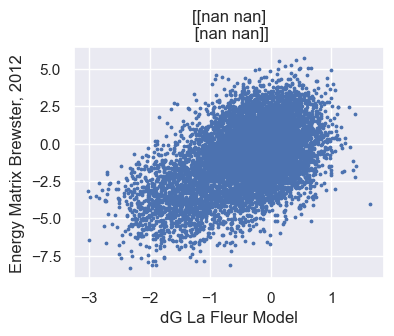

In [108]:
fig, ax = plt.subplots()

ax.set_ylabel("Energy Matrix Brewster, 2012")
ax.set_xlabel("dG La Fleur Model")
ax.scatter(df_sites['epsilon_model'], df_sites['epsilon'], s=3);

### Compare regulatory architectures

#### Simple repression and simple activation

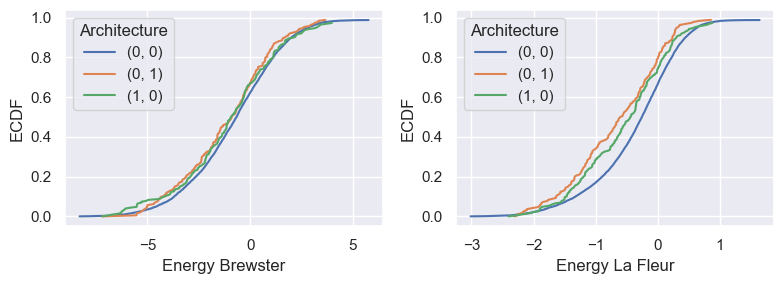

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].set_ylabel("ECDF")
ax[0].set_xlabel("Energy Brewster")

ax[1].set_ylabel("ECDF")
ax[1].set_xlabel("Energy La Fleur")

for arch in [(0, 0), (0, 1), (1, 0)]:
    x = df_sites.loc[df_sites['architecture'] == arch, "epsilon"].values
    ax[0].plot(np.sort(x), np.arange(len(x))/len(x), label=arch)

    x = df_sites.loc[df_sites['architecture'] == arch, "epsilon_model"].values
    ax[1].plot(np.sort(x), np.arange(len(x))/len(x), label=arch)
fig.tight_layout()
ax[0].legend(title="Architecture")
ax[1].legend(title="Architecture")

#### Double repression and double activation

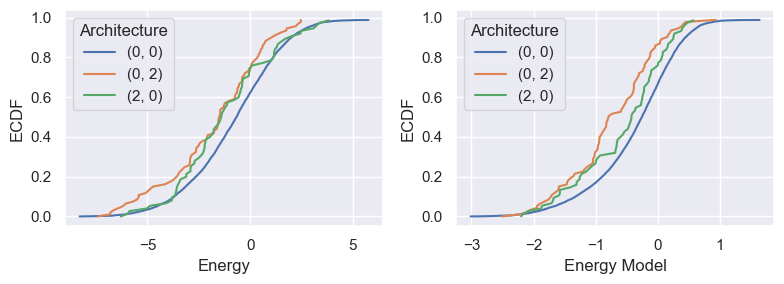

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].set_ylabel("ECDF")
ax[0].set_xlabel("Energy Brewster")

ax[1].set_ylabel("ECDF")
ax[1].set_xlabel("Energy La Fleur")

for arch in [(0, 0), (0, 2), (2, 0)]:
    x = df_sites.loc[df_sites['architecture'] == arch, "epsilon"].values
    ax[0].plot(np.sort(x), np.arange(len(x))/len(x), label=arch)

    x = df_sites.loc[df_sites['architecture'] == arch, "epsilon_model"].values
    ax[1].plot(np.sort(x), np.arange(len(x))/len(x), label=arch)

fig.tight_layout()
ax[0].legend(title="Architecture")
ax[1].legend(title="Architecture")